In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

# Data Cleaning and Insights

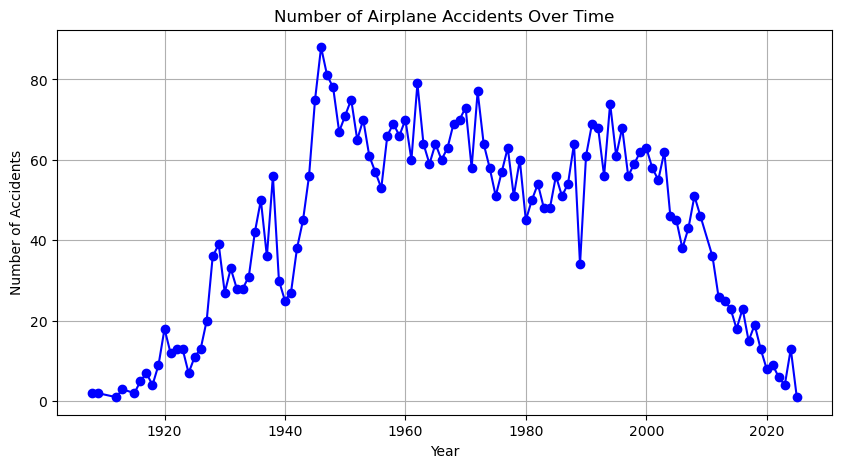

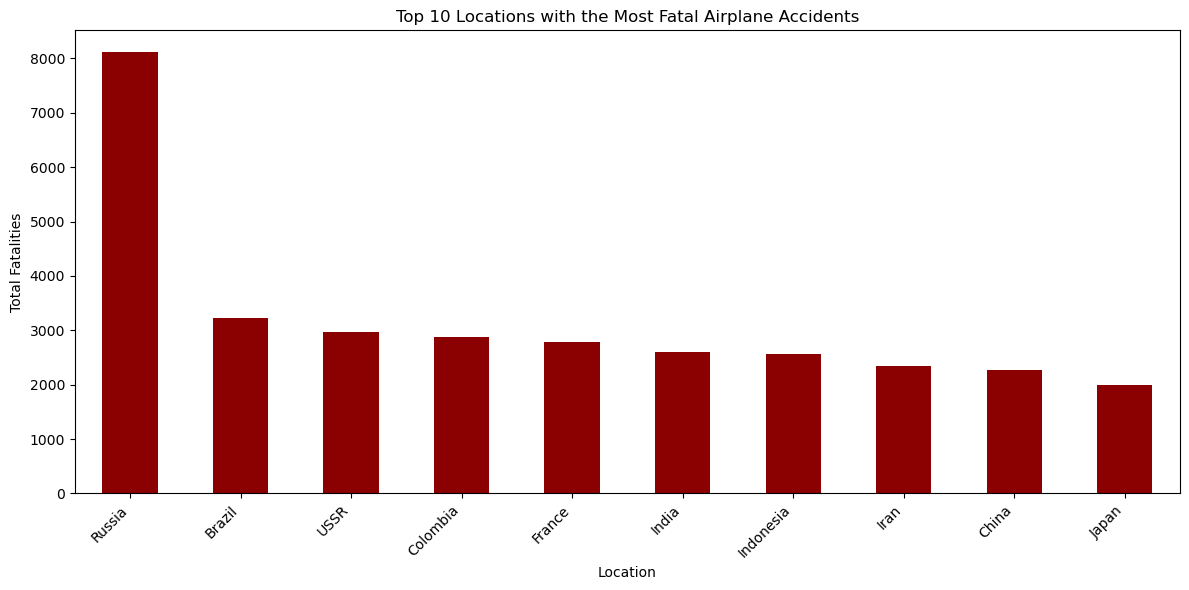

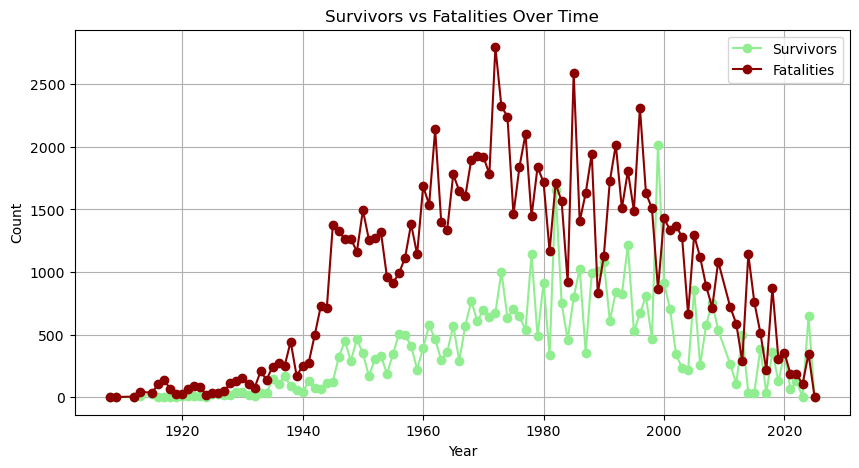

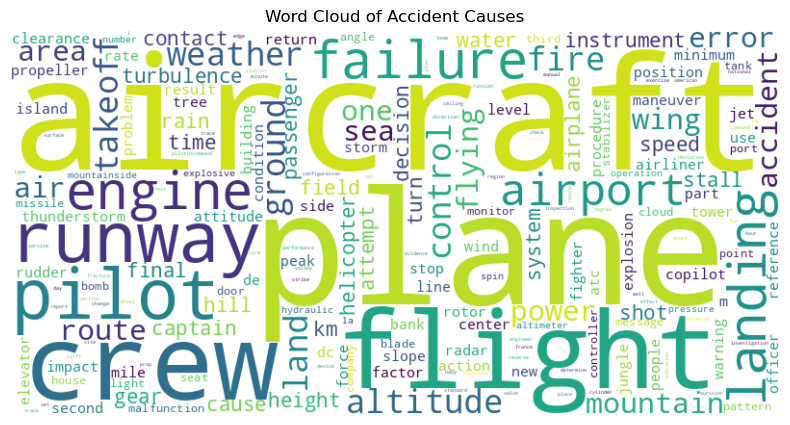

In [3]:
raw_data = pd.read_csv('plane_crashes.csv', header=None, encoding='utf-8', names=['Date', 'Location', 'Aboard', 'Fatalitites', 'Summary'])

def clean_data(data):
    cleaned_data = pd.DataFrame()

    # Extract only the year from the Date field
    cleaned_data['Date'] = data['Date'].str.extract(r'Date:([A-Za-z]+\s\d{1,2},\s\d{4})')[0]

    # Extract only the state from the Location field (state is at the end)
    cleaned_data['Location'] = data['Location'].str.extract(r'Location:.+,\s([A-Za-z\s]+)$')[0]

    # Extract 'Aboard' and clean the parentheses and the values within
    cleaned_data['Aboard'] = data['Aboard'].str.extract(r'Aboard:(\d+)')[0]

    # Extract 'Fatalities' and clean the parentheses and the values within
    cleaned_data['Fatalities'] = data['Fatalitites'].str.extract(r'Fatalities:(\d+)')[0]

    # Extract the summary, removing the 'Summary:' prefix
    cleaned_data['Summary'] = data['Summary'].str.extract(r'Summary:(.*)')[0]
    
    # Convert 'Date' to datetime format
    cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'], format='%B %d, %Y', errors='coerce')

    # Convert Aboard and Fatalities to integers
    cleaned_data['Aboard'] = pd.to_numeric(cleaned_data['Aboard'], errors='coerce')
    cleaned_data['Fatalities'] = pd.to_numeric(cleaned_data['Fatalities'], errors='coerce')
    
    # Calculate survivors (Aboard - Fatalities)
    cleaned_data['Survivors'] = cleaned_data['Aboard'] - cleaned_data['Fatalities']

    # Drop rows with invalid dates or essential data missing
    cleaned_data = cleaned_data.dropna(subset=['Date', 'Summary'])
    
    return cleaned_data


def analyze_causes(data):
    # Aggregate summary texts over time
    data['Year'] = data['Date'].dt.year
    grouped = data.groupby('Year')['Summary'].apply(lambda x: ' '.join(x)).reset_index()

    # Tokenize and count word frequency in summaries
    causes = ' '.join(grouped['Summary']).lower()
    causes = re.sub(r'[^a-zA-Z\s]', '', causes)  # Remove non-alphabetic characters
    word_counts = pd.Series(causes.split()).value_counts()

    return word_counts

# Visualize data
def visualize_data(data, word_counts):
    # 1. Plot accidents over time (from previous code)
    yearly_data = data.groupby('Year').size()
    plt.figure(figsize=(10, 5))
    plt.plot(yearly_data.index, yearly_data.values, marker='o', linestyle='-', color='b')
    plt.title('Number of Airplane Accidents Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Accidents')
    plt.grid()
    plt.show()

    # 3. Visualizing locations with the most fatal accidents
    location_fatalities = data.groupby('Location')['Fatalities'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(12, 6))
    location_fatalities.plot(kind='bar', color='darkred')
    plt.title('Top 10 Locations with the Most Fatal Airplane Accidents')
    plt.xlabel('Location')
    plt.ylabel('Total Fatalities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 4. Visualizing the proportion of survivors vs fatalities over time
    yearly_survivors = data.groupby('Year')['Survivors'].sum()
    yearly_fatalities = data.groupby('Year')['Fatalities'].sum()

    # Plot the proportion of survivors vs fatalities over time (line chart)
    plt.figure(figsize=(10, 5))
    plt.plot(yearly_survivors.index, yearly_survivors.values, marker='o', linestyle='-', label='Survivors', color='lightgreen')
    plt.plot(yearly_fatalities.index, yearly_fatalities.values, marker='o', linestyle='-', label='Fatalities', color='darkred')
    
    plt.title('Survivors vs Fatalities Over Time')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Generate word cloud for causes
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(word_counts.index))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Accident Causes')
    plt.show()
    
# Clean data
cleaned_data = clean_data(raw_data)
cleaned_data.to_csv('cleaned_plane_crahes.csv')

# Analyze causes
word_counts = analyze_causes(cleaned_data)

# Visualize data
visualize_data(cleaned_data, word_counts)